In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.STL10(root='./data', split='train',
                                        download=True, transform=transform) # cifar-10: 32*32, STL-10 96*96
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.STL10(root='./data', split='test',
                                
                                     download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [18]:
len(testset)

8000

In [17]:
len(testloader)

2000

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 7, stride=3) #in_channels: 3(r,g,b) out_channels: 6, kernel_size: 5
        # output:  (W-F+2P)/S+1 -> (96-7)/3+1 -> 30 (소수점 버림)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5) # 15-5+1 = 11
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # 15
        x = self.pool(F.relu(self.conv2(x))) # 5
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [27]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 1000 == 999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 1000))
            running_loss = 0.0

print('Finished Training')

[1,  1000] loss: 1.149
[2,  1000] loss: 1.074
Finished Training


In [28]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [29]:
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

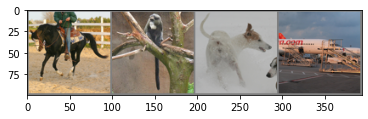

GroundTruth:  horse monkey   dog airplane


In [31]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [32]:
outputs = net(images)

In [33]:
outputs

tensor([[-3.4575,  3.3049, -7.5031,  2.2739, -0.0802,  7.6279,  7.3792,  5.4193,
         -6.8263, -7.4315],
        [-3.8183,  1.7570, -3.6224,  2.4912,  3.6442,  3.4241,  3.0595,  3.7237,
         -4.8884, -3.6194],
        [-1.6451,  2.5714, -1.9939,  2.0016, -0.3705,  1.7642,  0.0885,  2.3297,
         -1.7063, -1.9533],
        [ 1.8313, -1.0769,  0.4406, -0.3914, -0.4004, -1.5982, -1.3227, -1.8215,
          1.9815,  2.4208]], grad_fn=<AddmmBackward>)

In [34]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

Predicted:    dog monkey  bird truck


In [35]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 44 %


In [36]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of airplane : 69 %
Accuracy of  bird : 31 %
Accuracy of   car : 53 %
Accuracy of   cat : 26 %
Accuracy of  deer : 31 %
Accuracy of   dog : 30 %
Accuracy of horse : 31 %
Accuracy of monkey : 69 %
Accuracy of  ship : 43 %
Accuracy of truck : 62 %
